### 继MATLAB之后，对生成的数据进行处理

In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import librosa as lb
print(lb.__version__)

0.10.2.post1


In [7]:
# SSP Plotting using ARLPY

import arlpy.uwapm as pm
import arlpy.plot as plt
# add/change bathy to env

# add/change SSP to env
ssp = [
  [  0.0 , 1548.52],[200.0 , 1530.29],
  [400.0 , 1517.78],[600.0 , 1509.49 ],  
  [800.0 , 1504.30],[1000.0 , 1501.38],  
  [1200.0 ,1500.14],[1400.0 ,  1500.12],  
  [1600.0 ,1501.02],[1800.0 , 1502.57] , 
  [2000.0 , 1504.62],[2200.0 , 1507.02 ],  
  [2400.0 , 1509.69 ],[2600.0 , 1512.55 ],
  [2800.0 , 1515.56],[3000.0 , 1518.67 ],
  [ 3200.0 , 1521.85 ],[3400.0 , 1525.10 ],
  [3600.0 , 1528.38],[3800.0 , 1531.70],
  [4000.0 , 1535.04],[4200.0 , 1538.39],
  [4400.0 , 1541.76 ],[4600.0 , 1545.14],
  [4800.0 , 1548.52 ],[5000.0 , 1551.91]
]

# Appending ssp and bathy to existing env file
env = pm.create_env2d(
    depth=5000,
    soundspeed=ssp,
    bottom_soundspeed=1551.91,
    bottom_density=1200,
    bottom_absorption=1.0,
    tx_depth=200,
    rx_depth=400
)
pm.print_env(env)
print(pm.models())


                name : arlpy
   bottom_absorption : 1.0
      bottom_density : 1200
    bottom_roughness : 0
   bottom_soundspeed : 1551.91
               depth : 5000
        depth_interp : linear
           frequency : 25000
           max_angle : 80
           min_angle : -80
              nbeams : 0
            rx_depth : 400
            rx_range : 1000
          soundspeed : [[   0.   1548.52]
                        [ 200.   1530.29]
                        [ 400.   1517.78]
                        [ 600.   1509.49]
                        [ 800.   1504.3 ]
                        [1000.   1501.38]
                        [1200.   1500.14]
                        [1400.   1500.12]
                        [1600.   1501.02]
                        [1800.   1502.57]
                        [2000.   1504.62]
                        [2200.   1507.02]
                        [2400.   1509.69]
                        [2600.   1512.55]
                        [2800.   1515.56]
          

In [3]:
print(pm.models())
pm.plot_env(env, width=900)


[]


In [4]:
rays = pm.compute_eigenrays(env)
pm.plot_rays(rays, env=env, width=900)

ValueError: No suitable propagation model available

#### 读取数据

In [10]:
'''读取数据'''
import os
path = './audios'
category = 'echo1_costas_cw'

#第一声影区和会聚区回波
shad_1st_path  = os.path.join(path,category+'_1st_shadow.wav') 
convg_1st_path = os.path.join(path,category+'_1st_convergence.wav')

convg_1st_echo ,sr = lb.load(convg_1st_path)


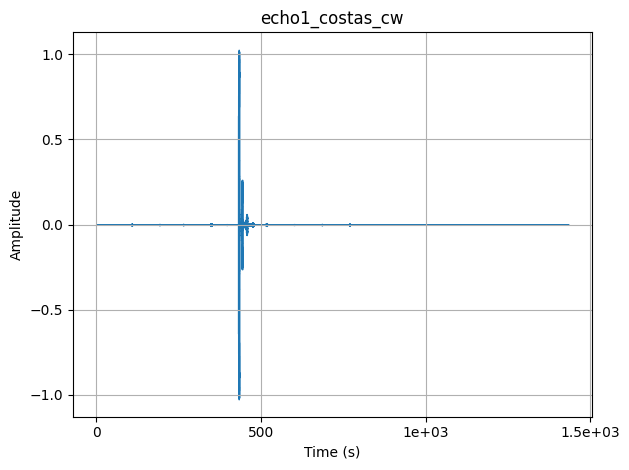

In [11]:
#读取采样率sr
sr = lb.get_samplerate(os.path.join(path, 'echo1_costas_cw_1st_shadow.wav'))
#绘制信号波形
lb.display.waveshow(convg_1st_echo, sr=sr,axis='s')
plt.title(category)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

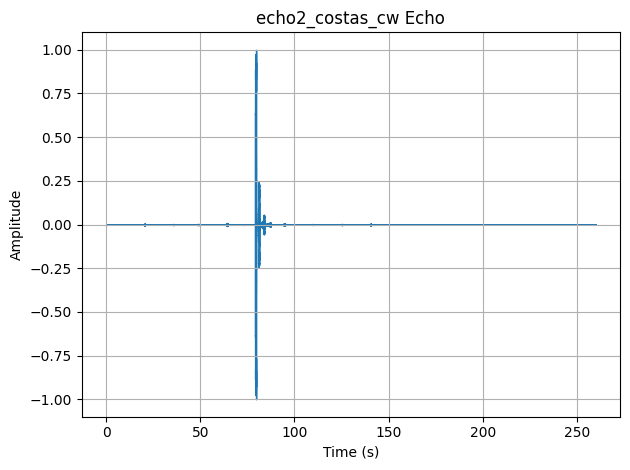

In [12]:
'''读取另一个波形的第一声影区和会聚区回波'''
category='echo2_costas_cw'
shad_1st_path, convg_1st_path = os.path.join(path,category+'_1st_shadow.wav'), os.path.join(path,category+'_1st_convergence.wav')

shad_1st_interference ,sr= lb.load(shad_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_interference ,sr= lb.load(convg_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_interference,shad_1st_interference = np.array(convg_1st_interference), np.array(shad_1st_interference)

#绘制信号波形
lb.display.waveshow(convg_1st_interference, sr=sr,axis='s')
plt.title(category+' Echo')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

### 添加噪声

In [13]:
def awgn(x, snr, out='signal', method='vectorized', axis=0):
    '''
    添加噪声,由matlab更改而来
    https://www.cnblogs.com/minyuan/p/14078114.html
    '''
    # Signal power
    if method == 'vectorized':
        N = x.size
        Ps = np.sum(x ** 2 / N)

    elif method == 'max_en':
        N = x.shape[axis]
        Ps = np.max(np.sum(x ** 2 / N, axis=axis))

    elif method == 'axial':
        N = x.shape[axis]
        Ps = np.sum(x ** 2 / N, axis=axis)
    else:
        raise ValueError('method \"' + str(method) + '\" not recognized.')
    # Signal power, in dB
    Psdb = 10 * np.log10(Ps)
    # Noise level necessary
    Pn = Psdb - snr
    # Noise vector (or matrix)
    n = np.sqrt(10 ** (Pn / 10)) * np.random.normal(0, 1, x.shape)
    if out == 'signal':
        return x + n
    elif out == 'noise':
        return n
    elif out == 'both':
        return x + n, n
    else:
        return x + n

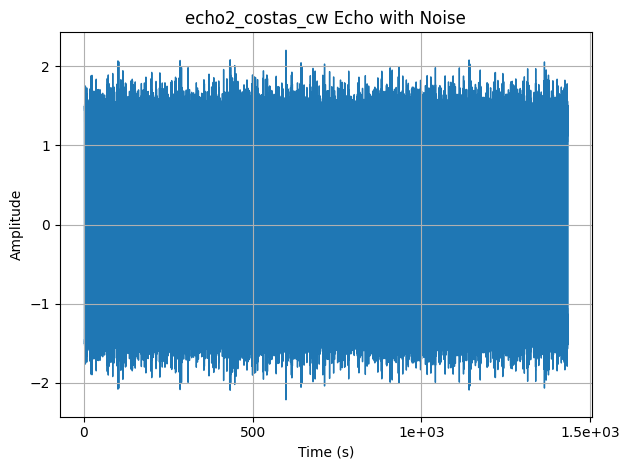

In [14]:
#添加白噪声
convg_1st_echo = awgn(convg_1st_echo,-25)  #-15dB
#绘制信号波形
lb.display.waveshow(convg_1st_echo, sr=sr,axis='s')
plt.title(category+' Echo with Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

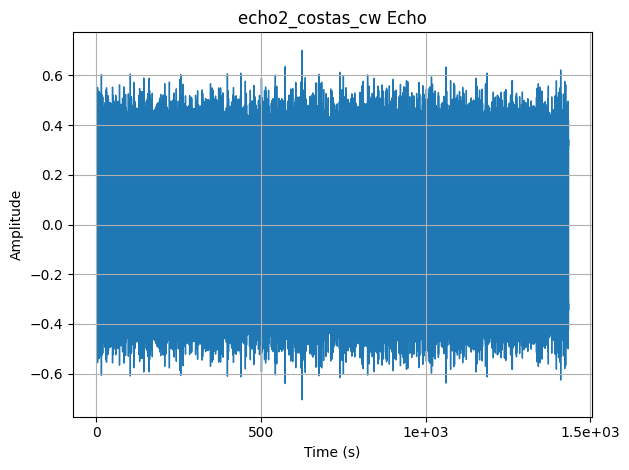

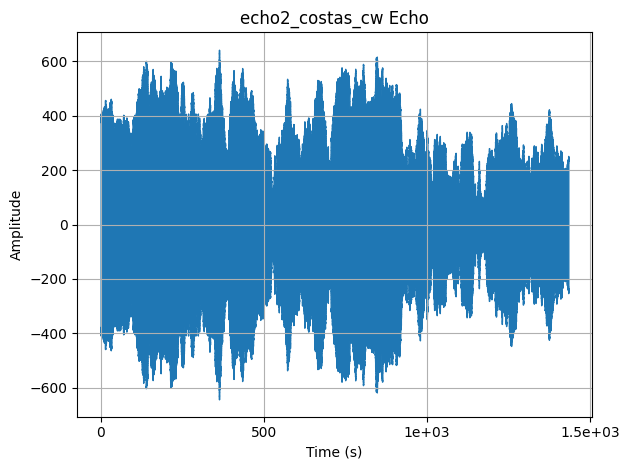

In [15]:
'''经过带通滤波器'''
from scipy import signal  # 带通滤波器
fmax = sr/2
f_start ,f_end= 1400/fmax ,1600/fmax
b, a  =   signal.butter( 8 , [ f_start , f_end ],  'bandpass' )    #配置滤波器 8 表示滤波器的阶数
out  =   signal.filtfilt(b, a, convg_1st_echo)   #data为要过滤的信号
#绘制信号波形
lb.display.waveshow(out, sr=sr,axis='s')
plt.title(category+' Echo')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

'''进行匹配滤波'''
t=np.arange(0,260-1/sr,1/sr)
template = np.sin(2 * np.pi * 1500 * t)  # 1500 Hz 的正弦波作为参考信号

# 匹配滤波：将输入信号与参考信号的时间反转版本进行卷积
matched_output = signal.fftconvolve(out, template[::-1], mode='same')

#绘制信号波形
lb.display.waveshow(matched_output, sr=sr,axis='s')
plt.title(category+' Echo')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()


### 分帧并计算每帧能量or过零率

In [16]:
#设定帧长和帧移
frame_length ,hop_length =2048, 512

# 对音频数据进行填充（必要步骤，可确保分帧完整）
padded_y = np.pad(matched_output, (frame_length // 2, frame_length // 2), mode='reflect')

#进行分帧
frames = lb.util.frame(padded_y, frame_length=frame_length, hop_length=hop_length)

# 计算每帧的能量
frame_energies = np.sum(np.abs(frames) ** 2, axis=0)


In [18]:
'''frames的每一列为一帧'''
print(f"帧数：{len(frames[0])}")
print(f"帧长：{len(frames[:,0])}")
#print(f"第一帧过零率：{zcrs[0,1]}")


帧数：2032
帧长：2048


In [22]:
avg_energies = frame_energies.mean()
vad_idx = []
'''结合能量检测'''
for i,energy in enumerate(frame_energies):
    if energy >= 0.5*avg_energies:
        vad_idx.append(i)


pulse_start = (vad_idx[0]*hop_length+frame_length)/sr
pulse_end = (vad_idx[-1]*hop_length+frame_length)/sr
pulse_len = pulse_end - pulse_start

print(f'脉冲的帧索引{vad_idx}')
print(f"脉冲长度{pulse_len}s")

# 保证结束索引不超过 frames 的最大列数
end_idx = min(vad_idx[-1] + 1, frames.shape[1])
extracted_frames = frames[:, vad_idx[0]:vad_idx[-1] + 1]

脉冲的帧索引[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

### 根据帧重构信号

In [23]:
def overlap_add(frames, frame_length, hop_length):
    '''重叠部分取平均值是一种常见的重构方法，使之平滑过渡，防止频谱失真
    假设 extracted_frames 是形状为 (num_frames, frame_length) 的数组
    frame_length 和 hop_length 是已知的帧长和帧移
    
    reconstructed_signal = overlap_add(extracted_frames, frame_length, hop_length)
    '''
    assert frames.shape[1] == frame_length, "frames 维度不匹配，可能需要转置"
    # 计算重构信号的总长度
    signal_length = frame_length + hop_length * (frames.shape[0] - 1)
    # 初始化重构信号
    reconstructed_signal = np.zeros(signal_length)
    # 初始化重叠加权数组
    overlap_count = np.zeros(signal_length)

    for i, frame in enumerate(frames):
        start = i * hop_length
        end = start + frame_length
        reconstructed_signal[start:end] += frame
        overlap_count[start:end] += 1

    # 处理重叠部分的平均值
    nonzero_indices = overlap_count > 0
    reconstructed_signal[nonzero_indices] /= overlap_count[nonzero_indices]

    return reconstructed_signal

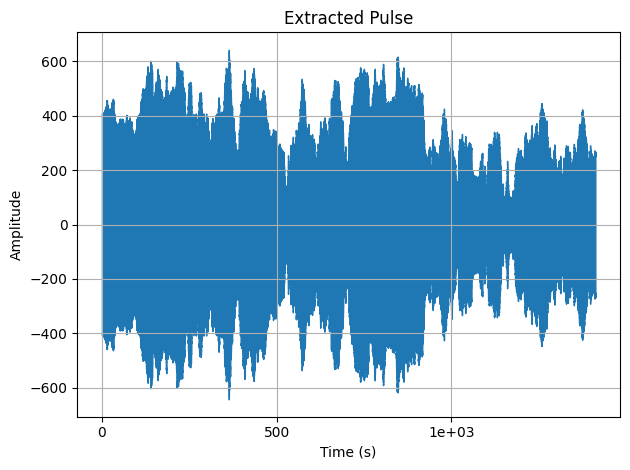

In [24]:
sig = overlap_add(extracted_frames.T, frame_length, hop_length)
lb.display.waveshow(sig, sr=sr,axis='s')
plt.title('Extracted Pulse')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()